## ResNeXt-50

ResNeXt-50의 구조

<img src="pic/ResNeXt50.png" width="400" height="450">

Cardinality

<img src="pic/cardinality.jpg" width="300" height="200">

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from torchsummary import summary
import time
import copy

c:\Users\root\anaconda3\envs\detectron_rev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ResNext Model

In [2]:
class BottleNeck(nn.Module):
    expansion = 4
    Cardinality = 32 # group 수
    Basewidth = 64 # bottleneck 채널이 64이면 group convolution의 채널은 depth
    Depth = 4 # basewidth일 때, group convolution의 채널 수
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        C = BottleNeck.Cardinality
        D = int(BottleNeck.Depth * out_channels / BottleNeck.Basewidth)

        self.conv_residual = nn.Sequential(
            nn.Conv2d(in_channels, C * D, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(C*D),
            nn.ReLU(),
            nn.Conv2d(C*D, C*D, 3, stride=stride, padding=1, groups=BottleNeck.Cardinality, bias=False),
            nn.BatchNorm2d(C*D),
            nn.ReLU(),
            nn.Conv2d(C*D, out_channels * BottleNeck.expansion, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion)
        )

        self.conv_shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.conv_shortcut = nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, 1, stride=stride, padding=0)

    def forward(self, x):
        x = self.conv_residual(x) + self.conv_shortcut(x)
        return x


# ResNext
class ResNext(nn.Module):
    def __init__(self, nblocks, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.conv2 = self._make_res_block(nblocks[0], 64, 1)
        self.conv3 = self._make_res_block(nblocks[1], 128, 2)
        self.conv4 = self._make_res_block(nblocks[2], 256, 2)
        self.conv5 = self._make_res_block(nblocks[3], 512, 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512 * BottleNeck.expansion, num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_res_block(self, nblock, out_channels, stride):
        strides = [stride] + [1] * (nblock-1)
        res_block = nn.Sequential()
        for i, stride in enumerate(strides):
            res_block.add_module('dens_layer_{}'.format(i), BottleNeck(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BottleNeck.expansion
        return res_block

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def ResNext50():
    return ResNext([3, 4, 6, 3])

In [3]:
# check model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 224, 224)).to(device)
model = ResNext50().to(device)
output = model(x)
print('output size: ', output.size())

output size:  torch.Size([3, 10])


In [4]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           9,408
       BatchNorm2d-2         [-1, 64, 111, 111]             128
              ReLU-3         [-1, 64, 111, 111]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
       BottleNeck-14          [-1, 256,

# Dataset

In [5]:
#Dataset
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Train

In [6]:
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

num_epoch = 10
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

#Train
loss_arr = []
accuracy_arr = []

for i in range(num_epoch):

    total_accuracy = 0.0

    for j,[image,label] in enumerate(tqdm(trainloader, desc=f'Epoch {i+1}/{num_epoch}')):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, y_)
        total_accuracy += batch_accuracy

    avg_accuracy = total_accuracy / len(trainloader)
    accuracy_arr.append(avg_accuracy)

    print(f'Epoch {i+1}/{num_epoch}, Loss: {loss}, Train Accuracy: {avg_accuracy * 100:.2f}%')
    loss_arr.append(loss.cpu().detach().numpy())

model_path = 'ResNext50.pth'

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_arr,
    }, model_path)

Epoch 1/10: 100%|██████████| 196/196 [00:39<00:00,  4.96it/s]


Epoch 1/10, Loss: 1.2645355463027954, Train Accuracy: 44.43%


Epoch 2/10: 100%|██████████| 196/196 [00:39<00:00,  4.94it/s]


Epoch 2/10, Loss: 1.080032467842102, Train Accuracy: 60.74%


Epoch 3/10: 100%|██████████| 196/196 [00:39<00:00,  4.93it/s]


Epoch 3/10, Loss: 0.9684934616088867, Train Accuracy: 67.94%


Epoch 4/10: 100%|██████████| 196/196 [00:39<00:00,  4.94it/s]


Epoch 4/10, Loss: 0.6771008968353271, Train Accuracy: 73.01%


Epoch 5/10: 100%|██████████| 196/196 [00:39<00:00,  4.93it/s]


Epoch 5/10, Loss: 0.8275665044784546, Train Accuracy: 76.66%


Epoch 6/10: 100%|██████████| 196/196 [00:39<00:00,  4.93it/s]


Epoch 6/10, Loss: 0.8662371635437012, Train Accuracy: 79.54%


Epoch 7/10: 100%|██████████| 196/196 [00:39<00:00,  4.95it/s]


Epoch 7/10, Loss: 0.5276261568069458, Train Accuracy: 82.65%


Epoch 8/10: 100%|██████████| 196/196 [00:39<00:00,  4.95it/s]


Epoch 8/10, Loss: 0.4674221873283386, Train Accuracy: 84.29%


Epoch 9/10: 100%|██████████| 196/196 [00:39<00:00,  4.95it/s]


Epoch 9/10, Loss: 0.623924732208252, Train Accuracy: 86.13%


Epoch 10/10: 100%|██████████| 196/196 [00:39<00:00,  4.94it/s]


Epoch 10/10, Loss: 0.5916658639907837, Train Accuracy: 87.22%


# Train Visualize

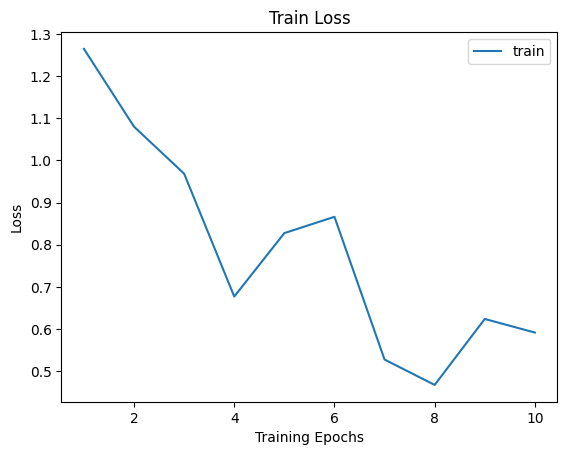

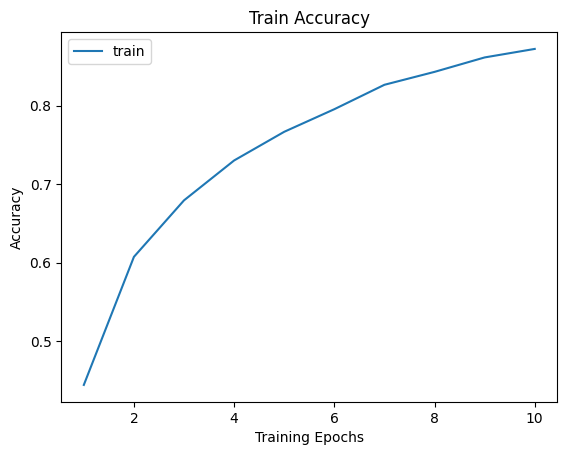

In [7]:
# plot loss progress
plt.title('Train Loss')
plt.plot(range(1, num_epoch+1), loss_arr, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train Accuracy')
plt.plot(range(1, num_epoch+1), accuracy_arr, label='train')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# Test

In [9]:
model_path = 'ResNext50.pth'

model = ResNext50().to(device)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

with torch.no_grad():
    for image, label in testloader:
        x = image.to(device)
        y_ = label.to(device)
        output = model(x)
        
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == y_).sum().item() / len(y_)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 81.25%
